Atividade 4: Partindo do mesmo conjunto de dados da Atividade 3  e mantendo a extração em vírgula flutuante, realizar o processamento em vírgula fixa do sinal ao longo do modelo MP e calcular o NMSE em função da quantidade de bits.

I. Normalizar os dados in e out fornecidos previamente de tal forma a garantir que as partes real e imaginária de todos os sinais envolvidos seja 1, da seguinte forma:
a) obter os valores máximos de  "max(abs(real(in_extraction)))" "max(abs(real(out_extraction)))"  "max(abs(imag(in_extraction)))" "max(abs(imag(out_extraction)))"
"max(abs(real(in_validation)))" "max(abs(real(out_validation)))"  "max(abs(imag(in_validation)))" "max(abs(imag(out_validation)))". Chamar de maior_maximo o maior destes 8 valores;
b) dividir todos os sinais "in_extraction", "out_extraction", "in_validation" e "out_validation"  por maior_maximo (ou seja, todos os sinais serão divididos pelo mesmo valor);
c) salvar os sinais "in_extraction", "out_extraction", "in_validation" e "out_validation" normalizados no item I.b.

II. Extrair novamente os coeficientes do MP para P=5 e M=1, idem ao feito na Atividade 3, porém agora usando o conjunto "in_extraction" e "out_extraction" normalizado em I.c).

III. Com os coeficientes extraídos em II e usando o conjunto "in_validation" e "out_validation" normalizado no item I.b., converter para vírgula fixa e calcular o NMSE ao variar da quantidade de bits usados, da seguinte forma:
a. Converter números decimais em números inteiros. Sugestão: primeiro multiplicar o número decimal por 2^inteiro. Na sequência arredondá-lo (aqui há 3 opções: floor, round, ceil). Acredito que o melhor seja round. Considerando que o valor máximo é 1, então o "inteiro" definirá a precisão em decimais. Por exemplo: com inteiro=2, a precisão é 0,25; com inteiro=10, a precisão é 0,0009765625.
b. Após a  realização de cada multiplicação entre 2 números convertidos para inteiro, é necessário readequar. Em específico, é necessário primeiro dividir o resultado por 2^inteiro e então arredondar para baixo (aqui é necessário usar o floor). Isso é equivalente a desconsiderar metade dos bits menos significativos.
c. Converter números inteiros em números decimais. Sugestão: dividir o número por 2^inteiro.
d. Overflow: após a realização de cada operação (soma ou multiplicação), você deve verificar qual foi o resultado obtido. Em específico, o objetivo é anotar qual é o maior módulo (ou seja, maior valor positivo ou menor negativo) manipulado durante todo o procedimento. Esse valor irá definir qual a quantidade de bits adicionais para evitar overflow. Por exemplo, considerando que a normalização foi feita assumindo máximo igual a 1: se o maior valor encontrado for 3 (que é maior que 2 e menor que 4), bastam adicionar 2 bits; se o maior valor encontrado for 6 (que é maior que 4 e menor que 8), bastam adicionar 3 bits.
e. A quantidade total de bits é: bits de precisão + 1bit de sinal + bits extras para evitar overflow.


In [ ]:
from functions import *

mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction']
out_data_ext = mat['out_extraction']
in_data_val = mat['in_validation']
out_data_val = mat['out_validation']


lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm  = in_data_ext / maior_modulo
out_ext_norm = out_data_ext /maior_modulo
in_val_norm  = in_data_val/ maior_modulo
out_val_norm = out_data_val/ maior_modulo

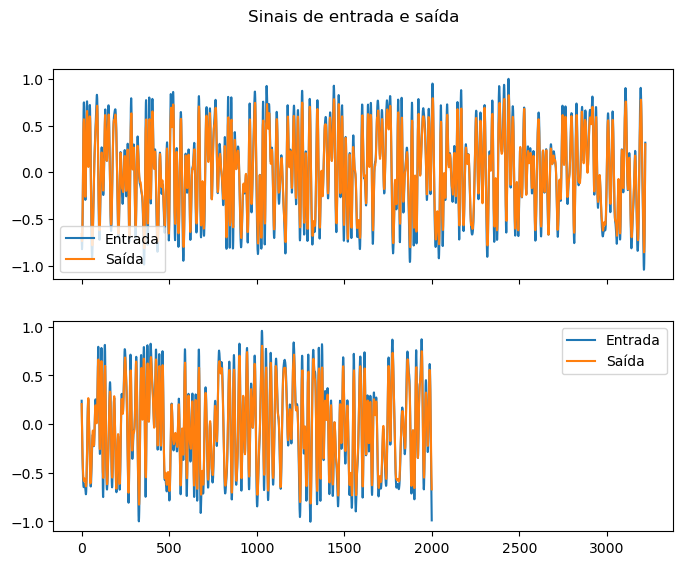

In [2]:
# plotar sinais de entrada e saída
x_ext = range(len(in_data_ext))
x_val = range(len(in_data_val))

fig, axs = plt.subplots(2, sharex=True, figsize=(8, 6))
fig.suptitle('Sinais de entrada e saída')
axs[0].plot(x_ext, np.real(in_ext_norm), label='Entrada')
axs[0].plot(x_ext, np.real(out_ext_norm), label='Saída')
axs[0].legend()
axs[1].plot(x_val, np.real(in_val_norm), label='Entrada')
axs[1].plot(x_val, np.real(out_val_norm), label='Saída')
axs[1].legend()
plt.show()

In [3]:
P = 2
M = 1
XX_val = mp(P, M, in_data_val)
XX_ext = mp(P, M, in_data_ext)
coefficients, _, _, _ = np.linalg.lstsq(XX_ext, out_data_ext[M:], rcond=None)
predicted_val = XX_val @ coefficients
nmse_target = nmse_calculo(predicted_val,out_data_val, M)


In [ ]:
XX_ext_norm = mp(P, M, in_ext_norm)
coefficients, _, _, _ = np.linalg.lstsq(XX_ext_norm, out_ext_norm[M:], rcond=None)

nmse_values = []

for p_bits in range(2, 20):
    # print(f'{np.round(coefficients * (2 ** p_bits))}')
    p_bits,e_bits, total_bits, nmse_fixed,_,_,_ = Calculo_do_modelo(P,M,p_bits, coefficients,in_val_norm,out_val_norm)
    nmse_values.append((p_bits,e_bits, total_bits, nmse_fixed))

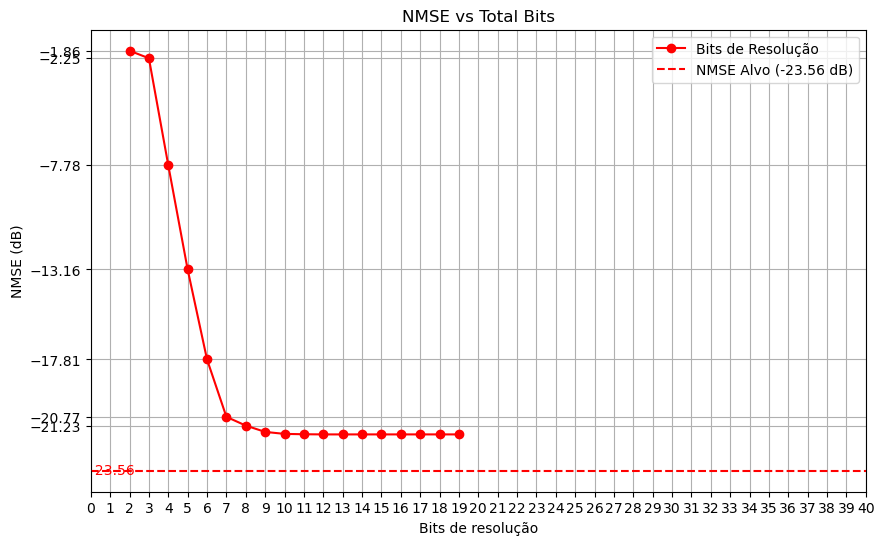

In [ ]:
nmse_values = np.array(nmse_values)
total_bits_array = nmse_values[:, 2]
resol_bits_array = nmse_values[:, 0]
nmse_fixed_array = nmse_values[:, 3]

plt.figure(figsize=(10, 6))
# plt.plot(total_bits_array, nmse_fixed_array, marker='o', linestyle='-', color='b', label='Bits Totais')
plt.plot(resol_bits_array, nmse_fixed_array, marker='o', linestyle='-', color='r', label='Bits de Resolução')

# Adicionar títulos e labels
plt.title('NMSE vs de resolução')
plt.xlabel('Bits de resolução')
plt.ylabel('NMSE (dB)')
plt.xticks(np.arange(0, max(total_bits_array) + 2, 1))
plt.yticks(nmse_fixed_array[:7])

plt.axhline(y=nmse_target, color='r', linestyle='--', label=f'NMSE Alvo ({nmse_target:.4} dB)')
plt.text(0, nmse_target, f'{nmse_target:.4}', color='r', verticalalignment='center')

plt.legend()
plt.grid(True)
plt.show()

In [6]:
bits_total = 17

bits_resol = nmse_values[nmse_values[:, 2] == bits_total, 0]
bits_overflow = nmse_values[nmse_values[:, 2] == bits_total, 1]
complex_numbers = coefficients * bits_resol[0]

In [7]:
complex_numbers

array([[ 1.11970796+0.95053056j],
       [ 6.75387544-1.03643953j],
       [-2.71430919-0.56025518j],
       [ 0.84282617+0.88433496j]])

In [8]:
output_file = r"VHDL\complex_constants.vhd"

vhdl_header = f"""\
  CONSTANT n_signals_used : INTEGER := {M + 1};
  CONSTANT n_polygnos_degree : INTEGER := {P};
  CONSTANT n_bits_resolution : INTEGER := {int(bits_resol[0])} + 1;
  CONSTANT n_bits_overflow : INTEGER := {int(bits_overflow[0])};

  CONSTANT max_value : INTEGER := 2 ** (n_bits_resolution - 1) - 1;
  CONSTANT max_value_overflow : INTEGER := 2 ** (n_bits_resolution + n_bits_overflow - 1) - 1;

  SUBTYPE limited_integer IS INTEGER RANGE -max_value TO max_value;
  SUBTYPE overflow_integer IS INTEGER RANGE -max_value_overflow TO max_value_overflow;
  TYPE complex_number IS RECORD
    reall : limited_integer;
    imag : limited_integer;
  END RECORD;

  TYPE complex_number_overflow IS RECORD
    reall : overflow_integer;
    imag : overflow_integer;
  END RECORD;

  TYPE complex_coefficients IS ARRAY (0 TO 3) OF complex_number;

  CONSTANT coefficients : complex_coefficients := (
"""
vhdl_footer = """\
  );
"""

# Função para converter um número complexo em uma string VHDL
complex_to_vhdl_string = lambda c : f"(reall => {int(np.round(c.real)[0])}, imag => {int(np.round(c.imag)[0])})"

# Gerando o conteúdo VHDL
vhdl_content = vhdl_header.format(size=len(complex_numbers) - 1, bits_resol = int(bits_resol[0]))
vhdl_content += ",\n".join([f"    {complex_to_vhdl_string(c)}" for c in complex_numbers])
vhdl_content += "\n" + vhdl_footer

# Escrevendo o conteúdo no arquivo
with open(output_file, "w") as f:
    f.write(vhdl_content)

print(f"Arquivo VHDL '{output_file}' gerado com sucesso!")

Arquivo VHDL 'VHDL\complex_constants.vhd' gerado com sucesso!


In [9]:
p_bits,e_bits, total_bits, nmse_fixed, in_val_fixed,out_val_fixed,predicted_val_fixed = Calculo_do_modelo(P,M,bits_resol, coefficients, in_val_norm, out_val_norm)

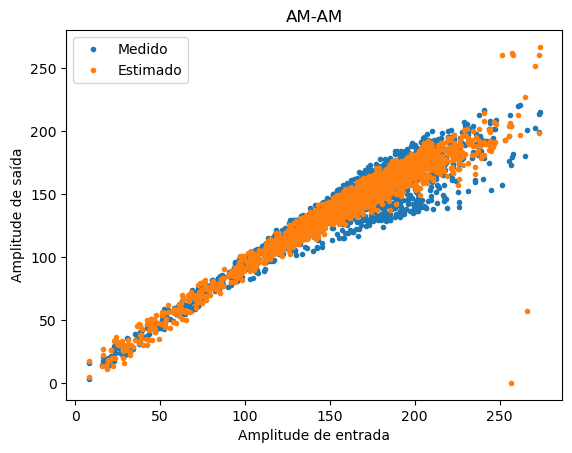

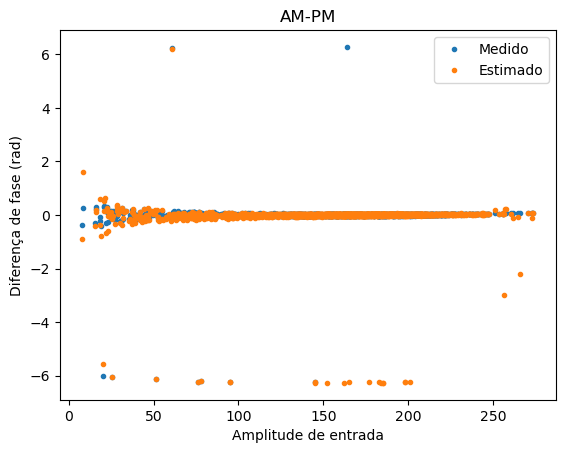

In [10]:
# Gráficos AM-AM e AM-PM
plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.abs(out_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.abs(predicted_val_fixed), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.angle(out_val_fixed[M:])-np.angle(in_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.angle(predicted_val_fixed)-np.angle(in_val_fixed[M:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Diferença de fase (rad)')
plt.title('AM-PM')
plt.legend()
plt.show()